In [31]:
# These are the imports, that are necessary for the project
import glob
import os
import pickle
import re
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from pathlib import Path
from PIL import Image
from sklearn.metrics import f1_score
from tensorflow.keras import regularizers, initializers, Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator, DirectoryIterator
from typing import Tuple

In [2]:
# Variables for amount of training data
start_train_data_amount = 10
train_data_amount_dif = 10

# Paths of data files
train_data_path = 'Train'
original_train_data_path = '../Train'
original_validation_data_path = '../Validation'
original_test_data_path = '../Test'

# Hyperparamter
batch_size = 24
learning_rate = 0.0001
kernel_s = (3, 3)
epochs, steps_per_epoch = 60, 100
early_stopping = EarlyStopping(monitor='val_loss', patience=10)  # Early stopping if model can't get better in training
# class_weight = {0: 1.0, 1: size_of_male_data / size_of_male_data}
class_weight = {0: 1.0, 1: 1.0}

In [36]:
# Find lower amount of data classes/sets -> use this number as maximum data set (e.g. male: 10,000 images and female: 15,000 images -> 10,000 = 100%)
original_train_data_path_male = Path(original_train_data_path) / "Male"
original_train_data_path_female = Path(original_train_data_path) / "Female"
male_data = [file_or_dir for file_or_dir in os.listdir(original_train_data_path_male)
                         if os.path.isfile(original_train_data_path_male / file_or_dir) and file_or_dir.endswith(".jpg")]
size_of_male_data = len(male_data)
female_data = [file_or_dir for file_or_dir in os.listdir(original_train_data_path_female)
                           if os.path.isfile(original_train_data_path_female / file_or_dir) and file_or_dir.endswith(".jpg")]
size_of_female_data = len(female_data)
max_data_size = min(size_of_female_data, size_of_male_data)

# Create training data by splitting subsets from original training data
for i in range(start_train_data_amount, 101, train_data_amount_dif):
    train_data_path_i = f"{train_data_path}_{i}%"
    print(f"{i}: {train_data_path_i}")

    if not os.path.exists(train_data_path_i) or not os.path.isdir(train_data_path_i):  # Use subset of training data
        # os.makedirs(train_data_path_i)  # Create directory for subset of training data

        # Create directory for male and female training data
        train_data_path_i_male = f"{train_data_path_i}/Male"
        train_data_path_i_female = f"{train_data_path_i}/Female"

        # Copy male data
        if not os.path.exists(train_data_path_i_male) or not os.path.isdir(train_data_path_i_male):
            os.makedirs(train_data_path_i_male)
            for male_datum in male_data[:int(max_data_size * (i / 100))]:
                os.system(f"cp {original_train_data_path}/Male/{male_datum} {train_data_path_i_male}")

        # Copy female data
        if not os.path.exists(train_data_path_i_female) or not os.path.isdir(train_data_path_i_female):
            os.makedirs(train_data_path_i_female)
            for female_datum in female_data[:int(max_data_size * (i / 100))]:
                os.system(f"cp {original_train_data_path}/Female/{female_datum} {train_data_path_i_female}")

10: Train_10%
20: Train_20%
30: Train_30%
40: Train_40%
50: Train_50%
60: Train_60%
70: Train_70%
80: Train_80%
90: Train_90%
100: Train_100%


In [33]:
def read_train_validate_test_data_from_file(training_data_path: Path, validation_data_path: Path, testing_data_path: Path,
                                            batch: int=batch_size) -> Tuple[DirectoryIterator, DirectoryIterator, DirectoryIterator]:
    # Read train data from file and augment data
    train_datagen = ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=(0.2, 0.8),  # low value = darker
        shear_range=0.3,
        zoom_range=0.3,
        channel_shift_range=0.5,  # Shifts channel (=rgb values) = seems to be similiar to brightness
        horizontal_flip=True,  # Horizontal flipping fits, vertical is not necessary
        rescale=1./255
    )

    train_gen=train_datagen.flow_from_directory(
        training_data_path,
        target_size=(250,250),
        batch_size=batch,
        class_mode='binary',
        shuffle=True
    )

    # Read validation data from file and augment data
    valid_datagen = ImageDataGenerator(rescale=1./255)

    valid_gen=valid_datagen.flow_from_directory(
        validation_data_path,
        target_size=(250,250),
        batch_size=batch,
        class_mode='binary',
        shuffle=True
    )

    # Read test data from file and augment data
    test_datagen = ImageDataGenerator(rescale=1./255)

    test_gen=test_datagen.flow_from_directory(
        testing_data_path,
        target_size=(250,250),
        batch_size=batch,
        class_mode='binary',
        shuffle=True
    )
    
    return train_gen, valid_gen, test_gen


def generate_model(filter_size: Tuple[int, int]=kernel_s) -> Sequential:
    return Sequential([
        Conv2D(32, filter_size, activation='relu', input_shape=(250,250,3), kernel_regularizer=regularizers.l2(0.001), padding="VALID"),
        MaxPooling2D((2,2)),

        Conv2D(64, filter_size, activation='relu'),
        MaxPooling2D((2,2)),

        Conv2D(64, filter_size, activation='relu'),
        MaxPooling2D((2,2)),

        Conv2D(128, filter_size, activation='relu'),
        MaxPooling2D((2,2)),

        Conv2D(128, filter_size, activation='relu'),
        MaxPooling2D((2,2)),

        # Last layer decise -> preparation for this = some layers before
        Flatten(),
        Dense(256, activation='relu'),
        # Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

In [18]:
# Read train, test and validate data for training a model + train model
histories = {}
accuracies = {}

for i in range(start_train_data_amount, 101, train_data_amount_dif):
    print(f"Start iteration: {i}% data")
    # batch_size_i = 12 if i == start_train_data_amount else batch_size
    batch_size_i = batch_size

    # Read train data from directory and augment data
    print("Search for new train, validation and test data")
    train_data_path_i = f"{train_data_path}_{i}%"
    train_gen, validation_data, test_gen = read_train_validate_test_data_from_file(train_data_path_i, original_validation_data_path, original_test_data_path, batch_size_i)
    # steps_per_epoch_i = len(train_gen) // batch_size_i
    steps_per_epoch_i = len(train_gen)

    # Create a model
    print("Create a model and train it")
    model = generate_model(kernel_s)
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['acc']
    )

    # Train model
    history = model.fit(
        train_gen, 
        validation_data=validation_data,
        steps_per_epoch=steps_per_epoch_i,
        epochs=epochs,
        callbacks=[early_stopping],
        class_weight=class_weight
    )
    
    # Test and save model
    accuracies[i] = model.evaluate(test_gen)  # Test model/Calculate Accuracy")
    histories[i] = history.history  # Save history of the model
    model.save(f"{train_data_path_i}/Gender_classification.keras")
    print("Done training the model\n")

# Write histories to file
with open('histories.pkl', 'wb') as history_file:
    pickle.dump(histories, history_file)

# Write accuracies to file
with open('accuracies.pkl', 'wb') as accuracy_file:
    pickle.dump(accuracies, accuracy_file)

Start iteration: 10% data
Search for new train, validation and test data
Train_10%
Found 1518 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1001 images belonging to 2 classes.
Create a model and train it
Epoch 1/60
64/64 [==============================] - 22s 315ms/step - loss: 0.6982 - acc: 0.5086 - val_loss: 0.6961 - val_acc: 0.6140
Epoch 2/60
64/64 [==============================] - 21s 320ms/step - loss: 0.6960 - acc: 0.5066 - val_loss: 0.7034 - val_acc: 0.4180
Epoch 3/60
64/64 [==============================] - 21s 322ms/step - loss: 0.6930 - acc: 0.5389 - val_loss: 0.6612 - val_acc: 0.6160
Epoch 4/60
64/64 [==============================] - 20s 317ms/step - loss: 0.6849 - acc: 0.5837 - val_loss: 0.6076 - val_acc: 0.6940
Epoch 5/60
64/64 [==============================] - 20s 316ms/step - loss: 0.6690 - acc: 0.6028 - val_loss: 0.6288 - val_acc: 0.6870
Epoch 6/60
64/64 [==============================] - 21s 326ms/step - loss: 0.6683 - acc: 0.5889 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



444/444 [==============================] - 132s 297ms/step - loss: 0.2908 - acc: 0.8833 - val_loss: 0.2209 - val_acc: 0.9140
Epoch 30/60
444/444 [==============================] - 136s 305ms/step - loss: 0.2936 - acc: 0.8842 - val_loss: 0.3016 - val_acc: 0.9140
Epoch 32/60
444/444 [==============================] - 132s 297ms/step - loss: 0.2828 - acc: 0.8847 - val_loss: 0.2287 - val_acc: 0.9050
Epoch 33/60
444/444 [==============================] - 133s 300ms/step - loss: 0.2781 - acc: 0.8910 - val_loss: 0.2822 - val_acc: 0.9090
Epoch 34/60
444/444 [==============================] - 132s 297ms/step - loss: 0.2779 - acc: 0.8902 - val_loss: 0.2587 - val_acc: 0.8970
Epoch 35/60
444/444 [==============================] - 132s 298ms/step - loss: 0.2846 - acc: 0.8884 - val_loss: 0.2013 - val_acc: 0.9200
Epoch 36/60
444/444 [==============================] - 132s 298ms/step - loss: 0.2738 - acc: 0.8911 - val_loss: 0.1877 - val_acc: 0.9320
Epoch 37/60
444/444 [==============================] 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



570/570 [==============================] - 169s 296ms/step - loss: 0.2619 - acc: 0.9020 - val_loss: 0.2172 - val_acc: 0.9050
Epoch 37/60
570/570 [==============================] - 169s 296ms/step - loss: 0.2643 - acc: 0.8993 - val_loss: 0.3069 - val_acc: 0.9040
Epoch 38/60
570/570 [==============================] - 170s 298ms/step - loss: 0.2677 - acc: 0.9000 - val_loss: 0.2562 - val_acc: 0.8850
Epoch 39/60
570/570 [==============================] - 169s 297ms/step - loss: 0.2607 - acc: 0.8976 - val_loss: 0.2316 - val_acc: 0.9380
Epoch 40/60
42/42 [==============================] - 2s 42ms/step - loss: 0.2214 - acc: 0.9071
Done training the model

Start iteration: 100% data
Search for new train, validation and test data
Train_100%
Found 15192 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1001 images belonging to 2 classes.
Create a model and train it
Epoch 1/60
633/633 [==============================] - 189s 297ms/step - loss: 0.6909 - acc: 0.5252 - val

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



633/633 [==============================] - 189s 299ms/step - loss: 0.6569 - acc: 0.6130 - val_loss: 0.5679 - val_acc: 0.7050
Epoch 3/60
633/633 [==============================] - 189s 299ms/step - loss: 0.6334 - acc: 0.6406 - val_loss: 0.5821 - val_acc: 0.6810
Epoch 4/60
633/633 [==============================] - 188s 297ms/step - loss: 0.6145 - acc: 0.6596 - val_loss: 0.5441 - val_acc: 0.7320
Epoch 5/60
633/633 [==============================] - 188s 297ms/step - loss: 0.6044 - acc: 0.6752 - val_loss: 0.5416 - val_acc: 0.7270
Epoch 6/60
633/633 [==============================] - 188s 298ms/step - loss: 0.5748 - acc: 0.7022 - val_loss: 0.5491 - val_acc: 0.7410
Epoch 7/60
633/633 [==============================] - 189s 298ms/step - loss: 0.5206 - acc: 0.7421 - val_loss: 0.5316 - val_acc: 0.7320
Epoch 8/60
633/633 [==============================] - 189s 299ms/step - loss: 0.4599 - acc: 0.7835 - val_loss: 0.3504 - val_acc: 0.8490
Epoch 9/60
633/633 [==============================] - 188s 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [5]:
# Read histories from file
with open('histories.pkl', 'rb') as history_file:
    histories = pickle.load(history_file)

# Read accuracies from file
with open('accuracies.pkl', 'rb') as accuracy_file:
    accuracies = pickle.load(accuracy_file)

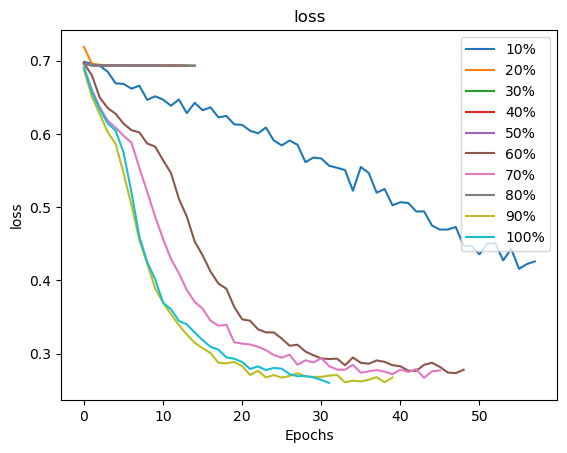

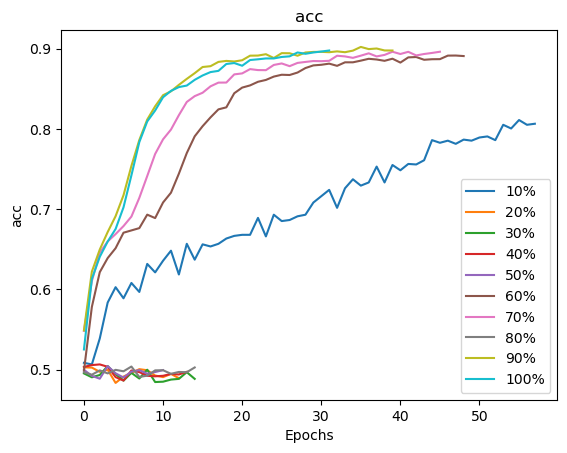

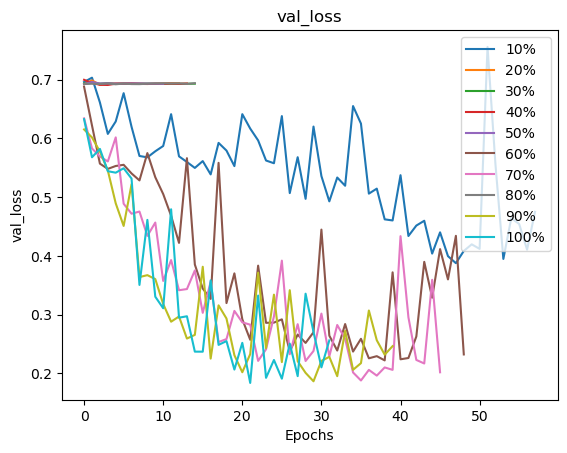

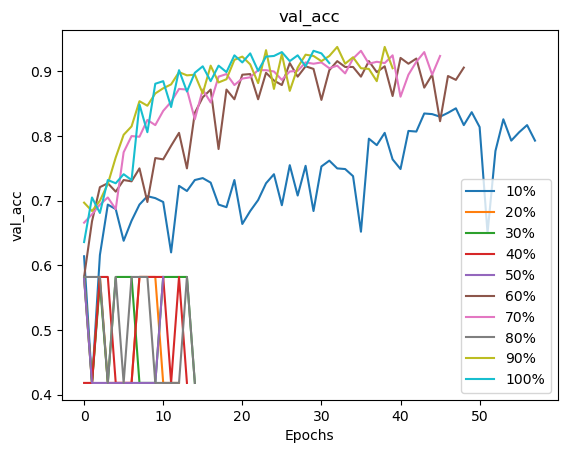

In [20]:
# Plot all histories
for critrium in list(histories.items())[0][1].keys():  # Iterate over 'loss', 'val_loss', 'acc' and 'val_acc'
    plt.title(critrium)

    for data_percentage, values in histories.items():  # Iterate over all data parts/percentages
        plt.plot(np.arange(len(values[critrium])), values[critrium], label=f"{data_percentage}%")
        plt.xlabel("Epochs")
        plt.ylabel(critrium)

    plt.legend()
    plt.show()

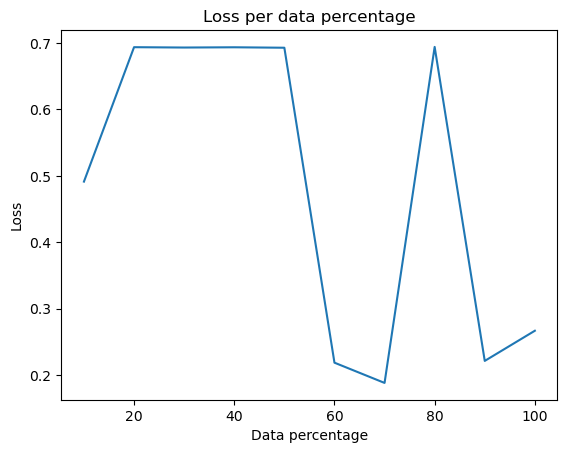

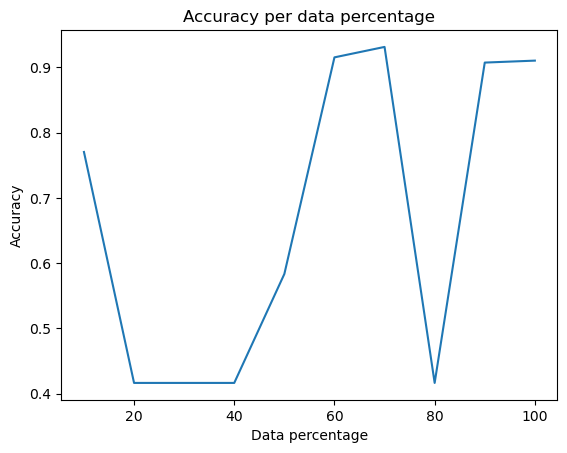

In [26]:
# Plot all accuracies: loss
plt.title("Loss per data percentage")
plt.plot(accuracies.keys(), [loss for loss, _ in accuracies.values()])
plt.xlabel("Data percentage")
plt.ylabel("Loss")
plt.show()

# Plot all accuracies: accuracy
plt.title("Accuracy per data percentage")
plt.plot(accuracies.keys(), [accuracy for _, accuracy in accuracies.values()])
plt.xlabel("Data percentage")
plt.ylabel("Accuracy")
plt.show()

<h1>Results</h1>
<br/>
<strong>60 % - 70 %</strong> data has best accuracies with overfitting epochs per episode (train data length / batch size)<br/>
-> Use <strong>60 % data</strong> because it leads to good results, although overfitting epochs per episode will be used and results are good. <strong>No need to use 100 % of data</strong> to get good results!<br/>
-> For this <strong>30 epochs</strong> already fits